## Programming Exercise*
Given the unnormalized density: $$p(x) = \exp(\frac{-x^2}{2})(\sin(x)^2+3\cos(x)^2\sin(7x)^2+1)$$ for $x\in[-3,3]$ , the task is to sample from this distribution and calculate $\mathbb{E}[x^2]$.

* Try rejection sampling with a uniform proposal,
* Try rejection sampling with a normal distribution,
* Try self-normalized importance sampling with a gaussian proposal,
* Repeat the previous sampling methods for sample sizes: {10, 100, 1000}. For each method and each sample size, calculate the mean and standard deviation of the estimator $\mathbb{E}[x^2]$, e.g. by repeating each simulation an appropriate number of times. Plot the values. Which method appears to perform better?

In [2]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro


smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.9.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')


Max Value: 3.8090250492095947
Max Value Normal: 9.780617713928223
Theoretical E[x^2]: 0.9147834811311186


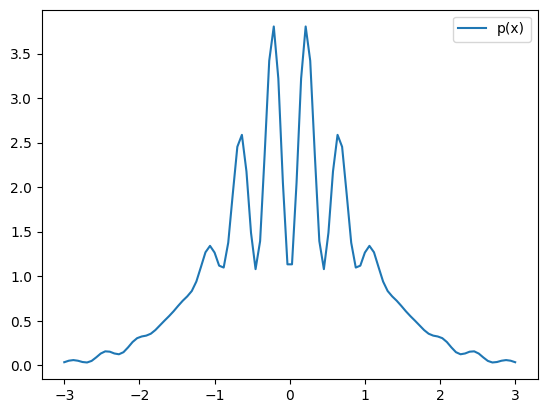

Sample Size 10: E[x²] ~ 0.8946 ± 1.1810


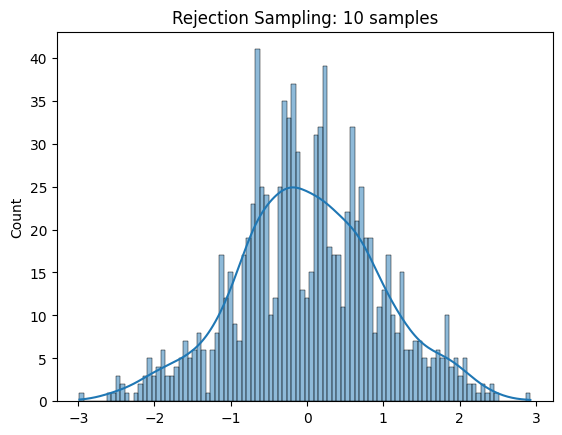

Sample Size 100: E[x²] ~ 0.8909 ± 1.2709


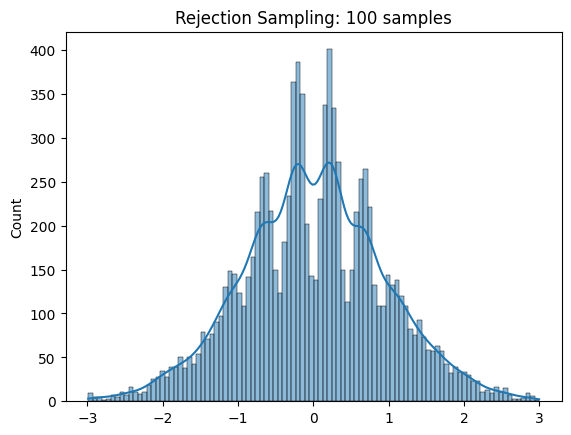

Sample Size 1000: E[x²] ~ 0.9192 ± 1.3111


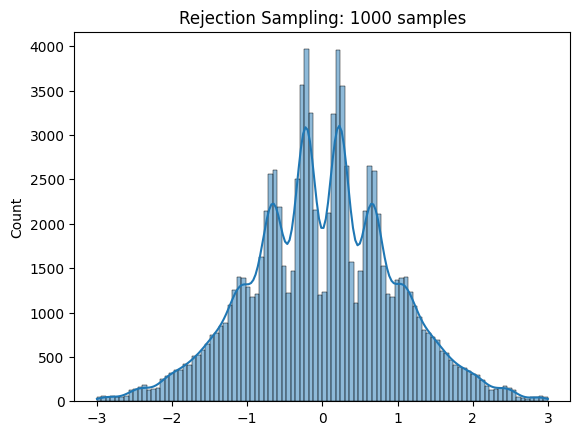

Sample Size 10: E[x²] ~ 0.4767 ± 0.6162


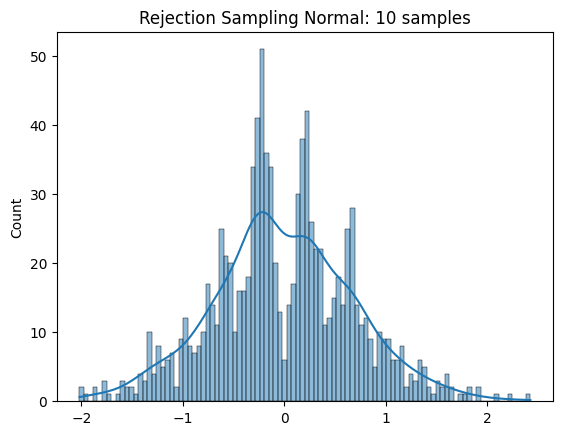

Sample Size 100: E[x²] ~ 0.4623 ± 0.6685


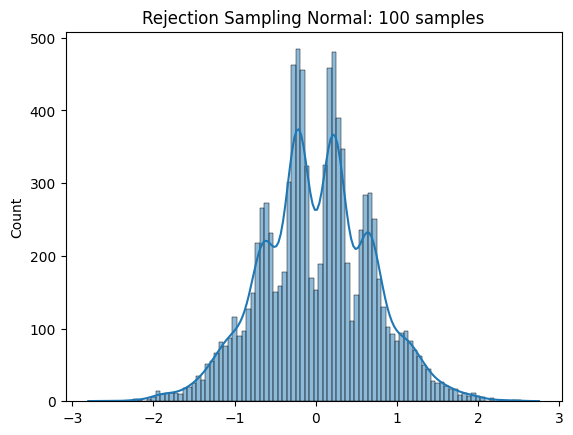

Sample Size 1000: E[x²] ~ 0.4575 ± 0.6755


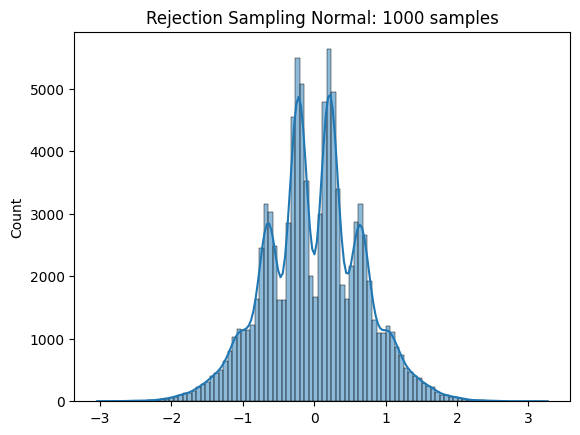

Sample Size 10: E[x²] ~ 0.0090 ± 0.0107


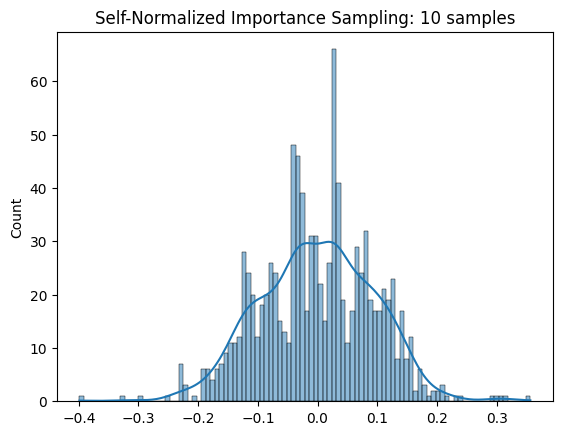

Sample Size 100: E[x²] ~ 0.0001 ± 0.0002


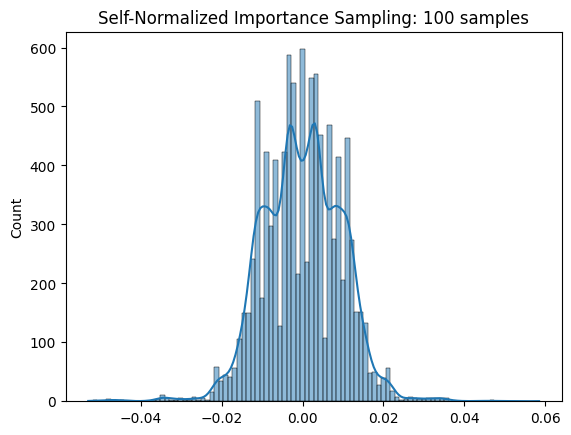

Sample Size 1000: E[x²] ~ 0.0000 ± 0.0000


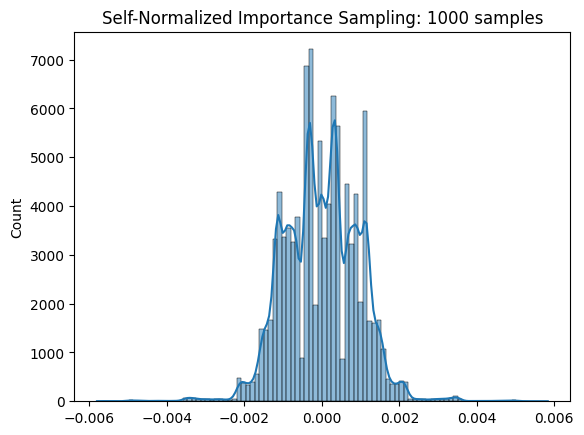

In [28]:
import pyro.distributions as dist
torch.manual_seed(42)

def p(x):
    if isinstance(x, float):
        x = torch.tensor(x)
    exp = torch.exp((-x**2)/2)
    sin_1 = torch.sin(x)**2
    cos = 3 * torch.cos(x)**2
    sin_2 = torch.sin(7*x)**2

    return exp * ((sin_1) + cos * sin_2 + (1))

x_values = torch.linspace(-3, 3, 1000)
max_value = torch.max(p(x_values))
print(f"Max Value: {max_value}")

def normal_pdf(x):
    return torch.exp(-x**2 / 2) / torch.sqrt(torch.tensor(2 * torch.pi))

q_normal_values = normal_pdf(x_values)
ratio_values = p(x_values) / q_normal_values
M_normal = torch.max(ratio_values)
print(f"Max Value Normal: {M_normal}")

def rejection_sampling(num_sample, max_density):
    proposal = dist.Uniform(-3, 3)
    samples = []
    while len(samples) < num_sample:
        x = proposal.sample()
        u = torch.rand(1)
        if u < p(x) / max_density:
            samples.append(x)
    return torch.stack(samples)

def rejection_sampling_normal(num_sample, max_value):
    proposal = dist.Normal(0, 1)
    samples = []
    while len(samples) < num_sample:
        x = proposal.sample()
        u = torch.rand(1)
        if u < p(x) / max_value:
            samples.append(x)
    return torch.stack(samples)

def self_normalized_importance_sampling(num_samples):
    proposal = dist.Normal(0, 1)
    samples = proposal.sample((num_samples,))
    weights = p(samples) / normal_pdf(samples)
    weights /= torch.sum(weights)
    samples = samples * weights
    return samples

from scipy.integrate import quad

# Compute the theoretical E[x^2]
# E[x^2] = ∫ x^2 p(x) dx / Z
# where Z = ∫ p(x) dx
Z, _ = quad(p, -3, 3)

def p_x2(x):
    return x**2 * p(x)

M, _ = quad(p_x2, -3, 3)

E_x2_theoretical = M / Z
print(f"Theoretical E[x^2]: {E_x2_theoretical}")


def plot_density():
    x = torch.linspace(-3, 3, 100)
    y = p(x)
    plt.plot(x.numpy(), y.numpy(), label='p(x)')
    plt.legend()
    plt.show()

def plot_samples(samples, title):
    sns.histplot(samples, bins=100, kde=True)
    plt.title(title)
    plt.show()

plot_density()


def run_experiment(sampling_fn, num_samples, max_value, title):
    means = []
    stds = []
    all_samples = []
    for _ in range(100):
        sample = sampling_fn(num_samples, max_value)
        squared_samples = sample**2
        means.append(torch.mean(squared_samples))
        stds.append(torch.std(squared_samples))
        all_samples.append(sample)
        
    mean_est = torch.mean(torch.tensor(means))
    std_est = torch.mean(torch.tensor(stds))
    
    print(f"Sample Size {num_samples}: E[x²] ~ {mean_est:.4f} ± {std_est:.4f}")

    combined_samples = torch.cat(all_samples)
    plot_samples(combined_samples, title)

def run_experiment_importance_sampling(sampling_fn, num_samples, title):
    means = []
    stds = []
    all_samples = []
    
    for _ in range(100):
        sample = sampling_fn(num_samples)
        squared_samples = sample**2
        means.append(torch.mean(squared_samples))
        stds.append(torch.std(squared_samples))
        all_samples.append(sample)
    
    mean_est = torch.mean(torch.tensor(means))
    std_est = torch.mean(torch.tensor(stds))
    
    print(f"Sample Size {num_samples}: E[x²] ~ {mean_est:.4f} ± {std_est:.4f}")

    combined_samples = torch.cat(all_samples)
    plot_samples(combined_samples, title)

run_experiment(rejection_sampling, 10, max_value, "Rejection Sampling: 10 samples")
run_experiment(rejection_sampling, 100, max_value, "Rejection Sampling: 100 samples")
run_experiment(rejection_sampling, 1000, max_value, "Rejection Sampling: 1000 samples")
run_experiment(rejection_sampling_normal, 10, M_normal, "Rejection Sampling Normal: 10 samples")
run_experiment(rejection_sampling_normal, 100, M_normal, "Rejection Sampling Normal: 100 samples")
run_experiment(rejection_sampling_normal, 1000, M_normal, "Rejection Sampling Normal: 1000 samples")
run_experiment_importance_sampling(self_normalized_importance_sampling, 10, "Self-Normalized Importance Sampling: 10 samples")
run_experiment_importance_sampling(self_normalized_importance_sampling, 100, "Self-Normalized Importance Sampling: 100 samples")
run_experiment_importance_sampling(self_normalized_importance_sampling, 1000, "Self-Normalized Importance Sampling: 1000 samples")

